# Practico Exploracion y curacion

-----

## Consignas

### 1. Curación de datos anómalos

Existe una cantidad de datos anómalos en el dataset y es necesario curarlos. Elegir y justificar una estrategia de imputación para los datos nulos.

### 2. Eliminación de outliers: 

En base en el estudio de outliers hecho en el practico 1, definan cotas inferiores y superiores para las variables que presenten outliers y filtren las filas que no cumplan con esos limites.

### 3. Balanceo de etiquetas:

La etiqueta positiva esta desbalanceada con respecto a la negativa. Esto se vio en el análisis de distribución sobre las distintas variables con respecto a la etiqueta. Existen distintos métodos para balanceo de etiquetas (ver notebooks over_sampling y under_sampling) así que vamos a probar algunos para ayudar a nuestros modelos del practico que viene.

- Usar al menos tres métodos de over-sampling para balancear el target. Uno de ellos tiene que ser RandomOverSampler
- Usar al menos tres métodos de under-sampling para balancear el target. Uno de ellos tiene que ser RandomUnderSampler

### 4. Escalado

Todas las métricas provenientes de la teoría de la información con excepción de ZE están escaladas entre 0 y 1. Es decir que tienen un mínimo en 0 y máximo en 1. Es necesario que todas nuestras features tengan la misma escala para que los modelos de ML funcionen mejor. Escalar LZE y las métricas de estadística clásica (media, varianza, skew) entre 0 y 1. (hint: MinMaxScaler)

### 5. PCA

Realizar PCA sobre el dataset original y acoplar las columnas generadas mas significativas al dataset. 

### Referencias

PCA: https://towardsdatascience.com/principal-component-analysis-3c39fbf5cb9d

Etiquetas no balanceadas: https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7#:~:text=3.%20Resampling%20to,imbalanced%2Dlearn%20library

imbalanced-learn: https://github.com/scikit-learn-contrib/imbalanced-learn

### 6. Ejercicio opcional: Analizando la columna GNE en busqueda de Mezclas Gaussianas

Dada la grafica de la distribucion de la columna que contiene esta metrica, podriamos inferir que se trata de una distribucion bimodal. Podemos intentar separar estas distribuciones usando el algoritmo Expectation-Maximization: https://scikit-learn.org/stable/modules/mixture.html#expectation-maximization 

La principal dificultad en modelar distribuciones bimodales o multimodales radica en diferenciar los puntos que pertenecen a los distintos componentes latentes. Expectation-Maximization hace un proceso iterativo para abordar ese problema. Primero asume componentes (medias o centros) aleatorias (o aprendidas con k-means), y luego computa para cada punto una probabilidad de haber sido generado por cada uno de los componentes del modelo. Luego, se modifican los parametros para alcanzar la maxima verosimilitud de los datos. Repitiendo este proceso se garantiza una convergencia. 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import linalg
from sklearn import mixture

sns.set_style("darkgrid")

<AxesSubplot:xlabel='GNE', ylabel='Count'>

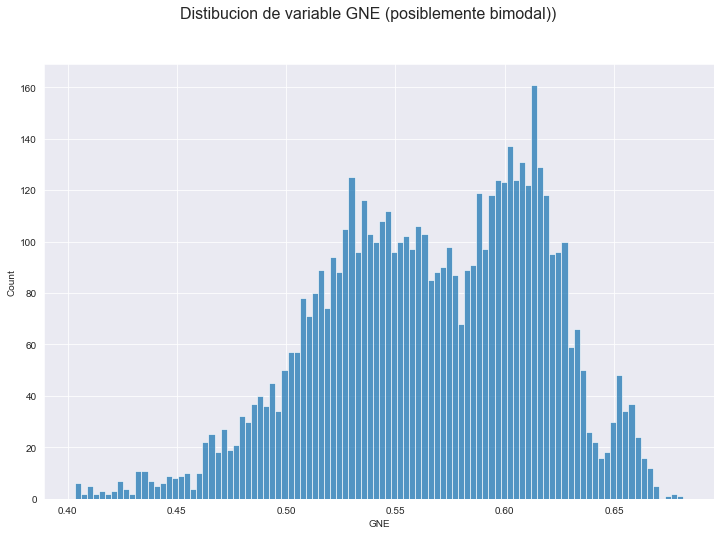

In [73]:
# Obtenemos los datos

df_etiquetados = []
df_no_etiquetados = []
filedir = "data_preprocessed"

from os import listdir

for file in listdir(filedir):
    if file[-4:] == ".csv":
        if "noEtiquetado" in file: df_no_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
        else: df_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
    else: print(file, " ---> no es csv")

for df in df_etiquetados: assert len(df.columns) == 11
for df in df_no_etiquetados: assert len(df.columns) == 10
    
df = pd.concat(df_etiquetados)

# Definir outliers segun los limites establecidos luego de analisis de practico 1
low_outlier_limit = 0.4
top_outlier_limit = 0.7

fig = plt.figure(figsize=(12,8))
fig.suptitle("Distibucion de variable GNE (posiblemente bimodal))", fontsize=16)
sns.histplot(df[(df["GNE"] > low_outlier_limit) & (df["GNE"] < top_outlier_limit)]["GNE"], bins=100)

<AxesSubplot:xlabel='data', ylabel='Count'>

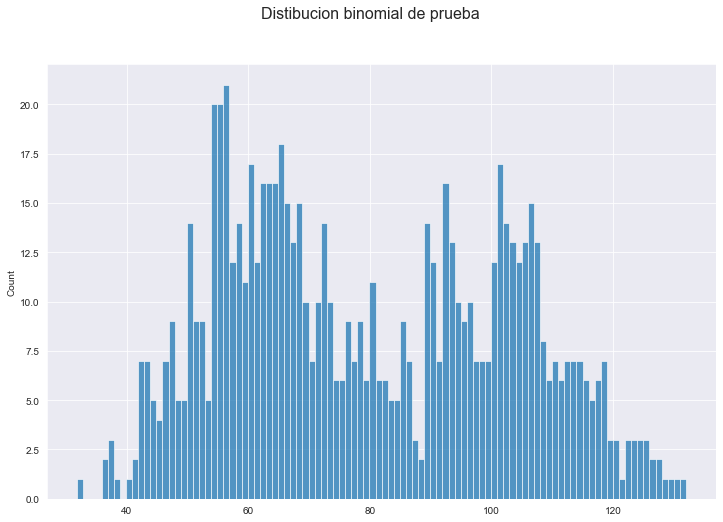

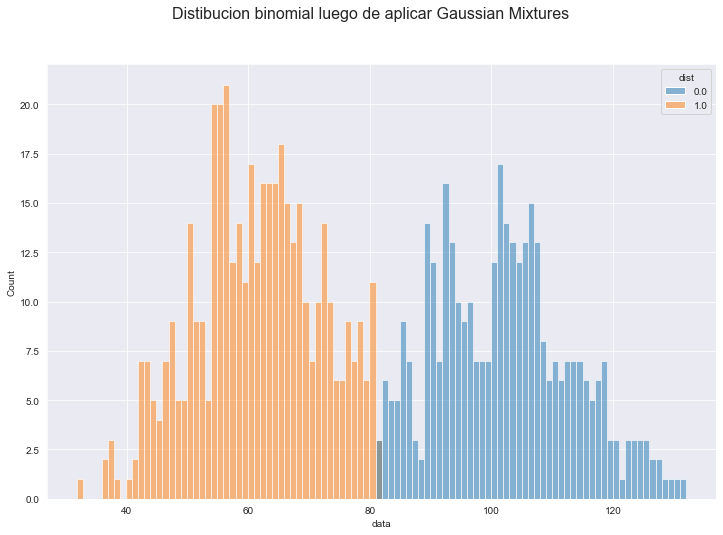

In [70]:
# Ditribucion bimodal de prueba (Reemplazar con GNE)

N=400
mu, sigma = 100, 13
mu2, sigma2 = 60, 10
X1 = np.random.normal(mu, sigma, N)
X2 = np.random.normal(mu2, sigma2, N)
X = np.concatenate([X1, X2])
fig = plt.figure(figsize=(12,8))
fig.suptitle("Distibucion binomial de prueba", fontsize=16)
sns.histplot(X, bins=100)

X = X.reshape(-1,1)

# Estimamos los centros usando el algoritmo de mezclas gaussianas, que internamente usa Expectation-Maximization
gmm = mixture.GaussianMixture(
            n_components=2, 
            covariance_type="spherical",
            init_params='kmeans'
        )
gmm.fit(X)

# Las predicciones emparejan un punto con un componente
bmod = np.column_stack((X,gmm.predict(X)))
bmod = pd.DataFrame(bmod, columns=["data", "dist"])

fig = plt.figure(figsize=(12,8))
fig.suptitle("Distibucion binomial luego de aplicar Gaussian Mixtures", fontsize=16)
sns.histplot(data=bmod, x = "data", hue="dist", bins=100)

Consignas:
- Aplicar GaussianMixtures sobre la columna GNE de la misma manera que hacemos en este ejemplo. Encontrar hiperparametros que se ajusten mejor a los datos de GNE (Ayudarse con la visualizacion de las distribuciones obtenidas) https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
- Incluir en el dataset original las etiquetas que determinan la distribucion a la que pertenece cada punto de GNE.